In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm

from pathlib import Path
from patsy import dmatrices

from notears import nonlinear, linear, utils
from graphviz import Digraph

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## Description

In this exercise you will work on the lighter version of the [Student Performance Data Set](https://archive.ics.uci.edu/ml/datasets/Student+Performance#) published in the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php).

We select only the subset of the columns:

1. address - student's home address type (binary: 'U' - urban or 'R' - rural)
2. higher - wants to take higher education (binary: yes or no)
3. internet - Internet access at home (binary: yes or no)
4. reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
5. G1 - first period grade (numeric: from 0 to 20)
6. absences - number of school absences (numeric: from 0 to 93)

Here we would like to try to measure the `ACE`(Average Causal Effect) of the `absences` on the `G1` from the observational data.

### Loading Data and Processing Data

In [29]:
data = pd.read_csv("student-por.csv", delimiter=';')[["absences", "address", "internet", "reason", "higher", "G1"]]
data = data[data.absences < 20]

data.head()

,absences,address,internet,reason,higher,G1
0,4,U,no,course,yes,0
1,2,U,yes,course,yes,9
2,6,U,yes,other,yes,12
3,0,U,yes,home,yes,14
4,0,U,no,home,yes,11


### Process Data 

Assign numerical values to string columns.  
*Note*: do not worry about details such as having one-hot encoders for non-binary columns. Treat them as ordinal values.

In [30]:
print(np.unique(data['address']))
data['address_numeric'] = 0
data.loc[  data['address'] == "R", 'address_numeric'  ] = 1
#R - 1
#U - 0

['R' 'U']


In [31]:
print(np.unique(data['internet']))
data['internet_numeric'] = 0
data.loc[  data['internet'] == "yes", 'internet_numeric'  ] = 1
#yes - 1
#no - 0

['no' 'yes']


In [32]:
print(np.unique(data['reason']))
data['reason_numeric'] = 0
data.loc[  data['reason'] == "home", 'reason_numeric'  ] = 1
data.loc[  data['reason'] == "other", 'reason_numeric'  ] = 2
data.loc[  data['reason'] == "reputation", 'reason_numeric'  ] = 3
# course - 0
# home  - 1
# other - 2
# reputation - 3

['course' 'home' 'other' 'reputation']


In [33]:
print(np.unique(data['higher']))
data['higher_numeric'] = 0
data.loc[  data['higher'] == "yes", 'higher_numeric'  ] = 1
#'yes' - 1
# NO  - 0

['no' 'yes']


### Visualize Data

See if you can find interesting patterns

### Stats and Visualization

In [34]:
def plot_bar(column):
    ax = data[column].value_counts().plot(kind='barh',
                                          figsize=(14,8),
                                          title=  column+ "")
    ax.set_ylabel(column)
    ax.set_xlabel("count")
    plt.show()
    
    ax = data.groupby([column])['G1'].mean().plot(kind='barh',
                                                  figsize=(14,8),
                                                  title= column + " and mean values")
    ax.set_xlabel("Mean G1 score")
    ax.set_ylabel(column)
    plt.show() 

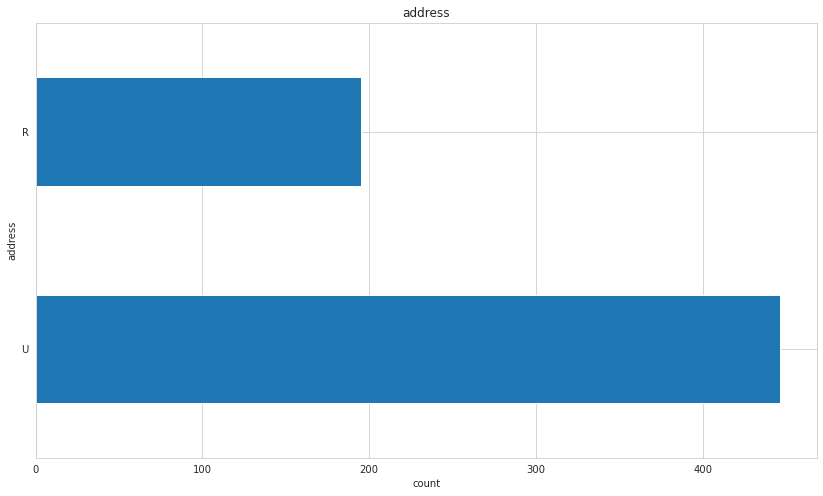

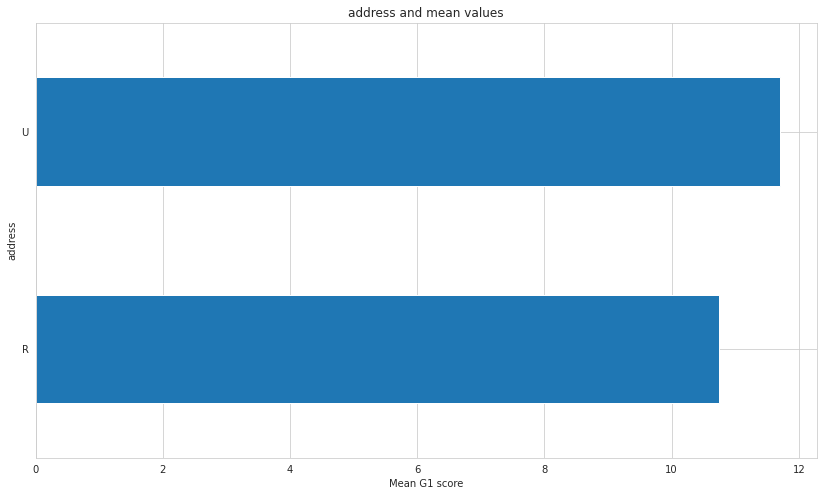

In [35]:
plot_bar('address')

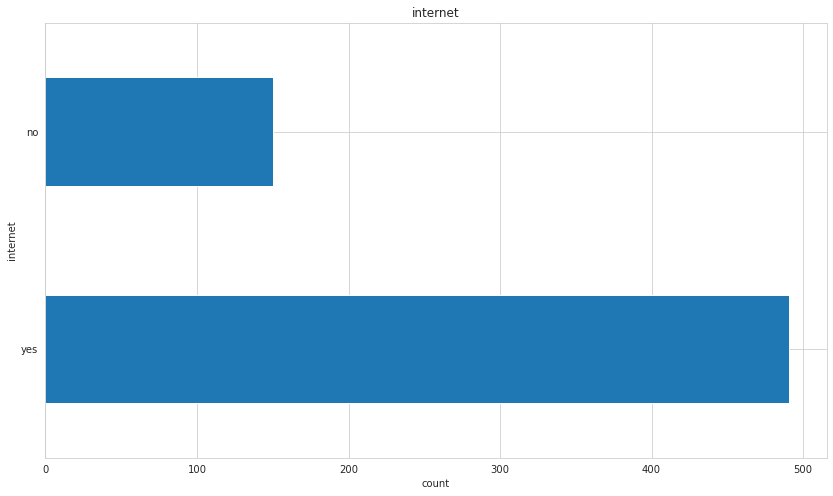

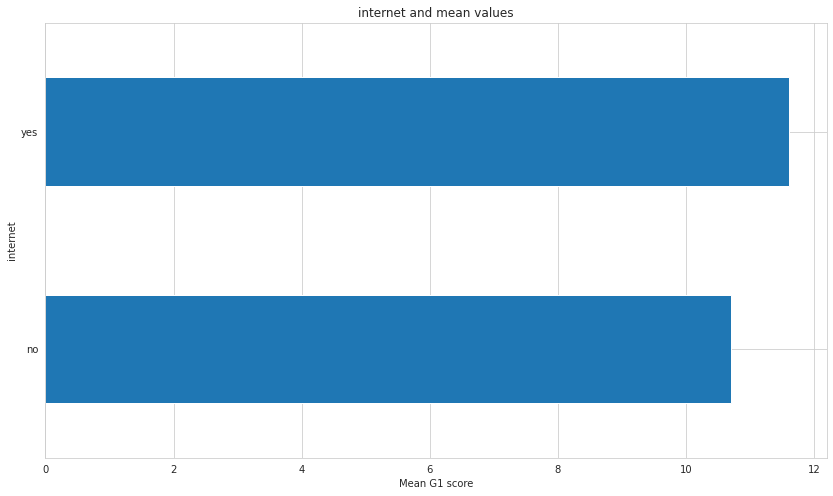

In [36]:
plot_bar('internet')

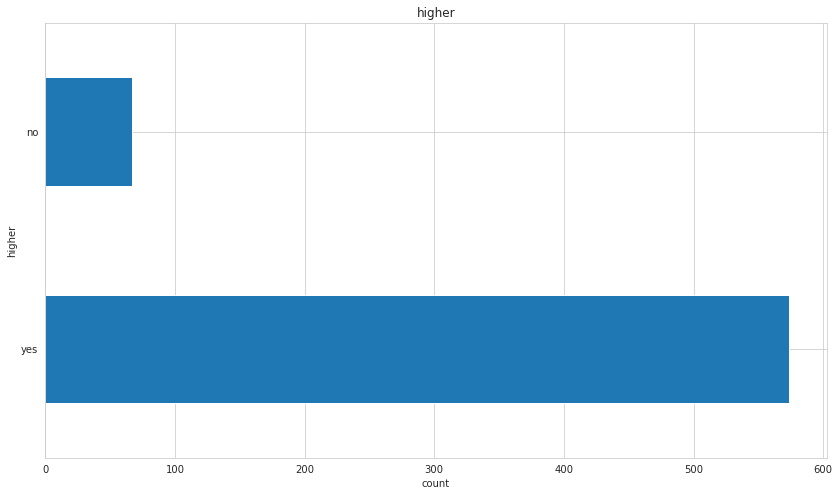

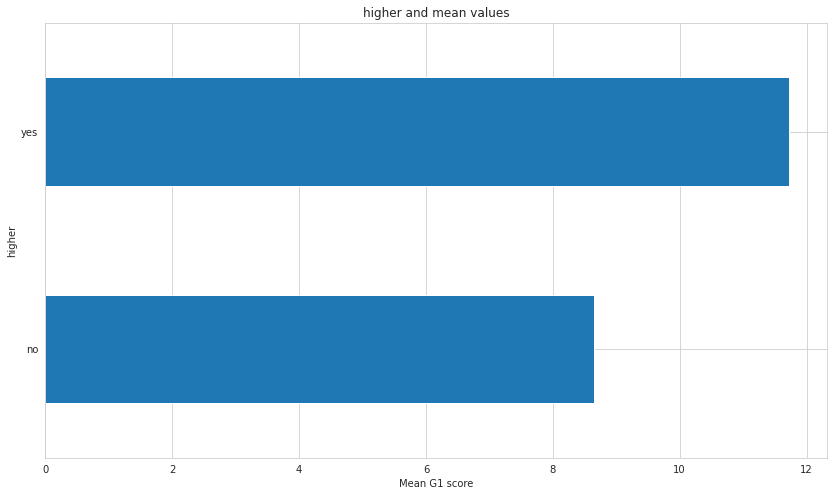

In [37]:
plot_bar('higher')

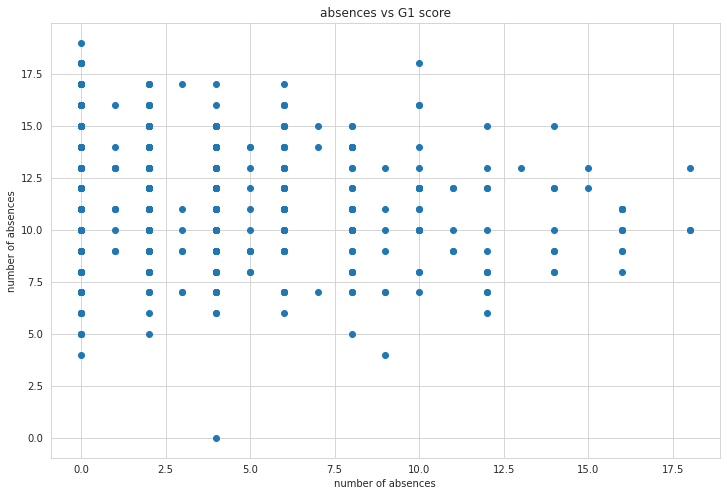

In [38]:
plt.scatter(data = data, x = "absences", y = "G1")
plt.title("absences vs G1 score")
plt.xlabel("number of absences")
plt.ylabel("number of absences")
plt.show()
## no linear relationship

### Naive Estimation: Part 1

Estimate the `absences` to `G1` naively using linear regression. 

To be consistent, please use statsmodels library for that. The API is:

```
sm.OLS.from_formula(formula="your_formula here", data=data) 
res = model.fit()
res.summary()
```

What do you observe here? 

In [39]:
model = sm.OLS.from_formula(formula="G1~absences", data=data) 
res = model.fit()
res.summary()
#R-squared ---> 0.026
# coef of  absences is not significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     17.37
Date:                Fri, 06 May 2022   Prob (F-statistic):           3.50e-05
Time:                        20:56:55   Log-Likelihood:                -1548.3
No. Observations:                 641   AIC:                             3101.
Df Residuals:                     639   BIC:                             3109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.7869      0.141     83.803      0.000      11.511      12.063
absences      -0.1118      0.027     -4.168      0.000      -0.164      -0.059
==============================================================================
Omnibus:                        0.654   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.721   Jarque-Bera (JB):                0.516
Skew:                          -0.055   Prob(JB):                        0.773
Kurtosis:                       3.084   Cond. No.                         6.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Naive Estimation Part 2

Now try to fit a linear regression using all available variables. 
 - What do you observe? 
 - What are the differences? 
 - What is the relative percentage difference between this estimate and previous one?
 - Which result to trust ?

In [40]:
model = sm.OLS.from_formula(formula="G1 ~ absences + address + internet + reason + higher", data=data) 
res = model.fit()
res.summary()
#better R-squerd
#reason = home coas positivly and significant
#reason= other coase neagtvly and significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     20.95
Date:                Fri, 06 May 2022   Prob (F-statistic):           1.98e-25
Time:                        20:56:56   Log-Likelihood:                -1490.1
No. Observations:                 641   AIC:                             2996.
Df Residuals:                     633   BIC:                             3032.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                8.1956      0.381     21.528      0.000       7.448       8.943
address[T.U]             0.7341      0.221      3.328      0.001       0.301       1.167
internet[T.yes]          0.5331      0.239      2.232      0.026       0.064       1.002
reason[T.home]           0.4391      0.258      1.700      0.090      -0.068       0.946
reason[T.other]         -0.2413      0.329     -0.733      0.464      -0.888       0.405
reason[T.reputation]     1.0117      0.260      3.892      0.000       0.501       1.522
higher[T.yes]            2.6166      0.328      7.977      0.000       1.972       3.261
absences                -0.1017      0.025     -4.065      0.000      -0.151      -0.053
==============================================================================
Omnibus:                        2.975   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                3.243
Skew:                          -0.036   Prob(JB):                        0.198
Kurtosis:                       3.341   Cond. No.                         26.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Learning DAG Structure

- Describe the structure you have learned
- Given the results from Naive Estimation Part2, is your graph consistent with the results or not?
- Where your learned structure is correct and where it is not?
- Wherever your Structure is incorrect complete the graph by adding/removing edges. (in case you add an edge, please color it red)

In [42]:
data_numeric = data.drop(['internet', 'address', 'reason', 'higher'], axis=1)
data_numeric.head()

,absences,G1,address_numeric,internet_numeric,reason_numeric,higher_numeric
0,4,0,0,0,0,1
1,2,9,0,1,0,1
2,6,12,0,1,2,1
3,0,14,0,1,1,1
4,0,11,0,0,1,1


In [43]:
np.random.seed(42)

weight_matrix = linear.notears_linear(data_numeric.values.astype(np.float32), lambda1=0.05, loss_type='l2')
assert utils.is_dag(weight_matrix)
weight_matrix

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.58174324, -0.55089586,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.41298946,  0.31260169,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.51928519,  2.36461683,  0.        ,  0.        ,  0.        ,
         0.        ]])

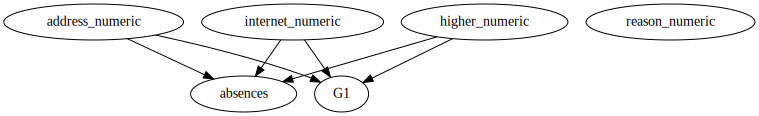

In [44]:
col_names  = data_numeric.columns.tolist()
num_cols = len(col_names)

dot = Digraph(comment='students', format='png')

for col in col_names:
    dot.node(col)

for ix in range(num_cols):
    edge_candidates = np.where(weight_matrix[ix, :] != 0)[0]
    for ec in edge_candidates:
        dot.edge(col_names[ix], col_names[ec], constraint="true")
        
dot

### Structural Equation Model (SEM)

- Write down the SEM corresponding to your graph

In [46]:
import semopy

In [48]:
model_spec = """
    # measurement model
     address_numeric =~ absences+G1
     higher_numeric =~ absences+G1
     internet_numeric =~ absences+G1
    # regression
     G1 ~ address_numeric+internet_numeric+higher_numeric

"""


# instantiate the model
model = semopy.Model(model_spec)

# fit the model using data
model.fit(data_numeric)

# show the results using inspect method

model.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,absences,~,address_numeric,1.000000,-,-,-
1,absences,~,higher_numeric,1.000000,-,-,-
2,absences,~,internet_numeric,1.000000,-,-,-
3,G1,~,address_numeric,-0.246370,0.03025,-8.14453,0.0
4,G1,~,higher_numeric,-0.246370,0.03025,-8.14453,0.0
5,G1,~,internet_numeric,-0.246370,0.03025,-8.14453,0.0
6,G1,~,address_numeric,-0.246370,0.03025,-8.14453,0.0
7,G1,~,internet_numeric,-0.246370,0.03025,-8.14453,0.0
8,G1,~,higher_numeric,-0.246370,0.03025,-8.14453,0.0
9,address_numeric,~~,address_numeric,0.522732,0.055632,9.39633,0.0


Coef estimates shows the coefficients that have the most impact

all p-values small (0.00)

the coefficients with highest estimates affect the most

In [66]:
model = sm.OLS.from_formula(formula="G1 ~ absences + address_numeric + internet_numeric+ higher_numeric", data=data_numeric) 
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     31.19
Date:                Fri, 06 May 2022   Prob (F-statistic):           9.78e-24
Time:                        21:39:24   Log-Likelihood:                -1499.5
No. Observations:                 641   AIC:                             3009.
Df Residuals:                     636   BIC:                             3031.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.9757      0.385     23.343      0.000       8.221       9.731
absences            -0.0958      0.025     -3.793      0.000      -0.145      -0.046
address_numeric     -0.7699      0.221     -3.486      0.001      -1.204      -0.336
internet_numeric     0.6585      0.240      2.746      0.006       0.188       1.130
higher_numeric       2.7767      0.330      8.416      0.000       2.129       3.425
==============================================================================
Omnibus:                        2.588   Durbin-Watson:                   1.660
Prob(Omnibus):                  0.274   Jarque-Bera (JB):                2.699
Skew:                          -0.043   Prob(JB):                        0.259
Kurtosis:                       3.306   Cond. No.                         26.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interventional Distribution

- Draw the graph corresponding to the Interventional Distribution

In [67]:
data_copy = data_numeric.copy()
data_copy = data_copy[data_copy['higher_numeric'] == 1] 
data_copy.head()

,absences,G1,address_numeric,internet_numeric,reason_numeric,higher_numeric
0,4,0,0,0,0,1
1,2,9,0,1,0,1
2,6,12,0,1,2,1
3,0,14,0,1,1,1
4,0,11,0,0,1,1


In [68]:
np.random.seed(42)

weight_matrix = linear.notears_linear(data_copy.values.astype(np.float32), lambda1=0.05, loss_type='l2')
assert utils.is_dag(weight_matrix)
weight_matrix

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.39877518, -0.58393915,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.31068973,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

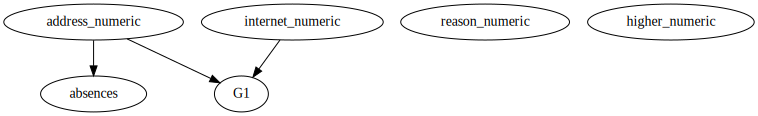

In [69]:
col_names  = data_copy.columns.tolist()
num_cols = len(col_names)

dot = Digraph(comment='students', format='png')

for col in col_names:
    dot.node(col)

for ix in range(num_cols):
    edge_candidates = np.where(weight_matrix[ix, :] != 0)[0]
    for ec in edge_candidates:
        dot.edge(col_names[ix], col_names[ec], constraint="true")
        
dot

### Estimating ACE

- Given a correct structure that you learned and modified from the previous example, fit a linear regression and estimate the `ACE` of `absences` on `G1`.
- Estimate relative percentage differences between Naive Estimation 1 and 2

In [73]:
model = sm.OLS.from_formula(formula="G1 ~ absences", data=data_copy) 
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     12.96
Date:                Fri, 06 May 2022   Prob (F-statistic):           0.000347
Time:                        21:40:09   Log-Likelihood:                -1367.0
No. Observations:                 574   AIC:                             2738.
Df Residuals:                     572   BIC:                             2747.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.0623      0.143     84.225      0.000      11.781      12.344
absences      -0.1030      0.029     -3.599      0.000      -0.159      -0.047
==============================================================================
Omnibus:                        2.457   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                2.337
Skew:                          -0.096   Prob(JB):                        0.311
Kurtosis:                       3.247   Cond. No.                         6.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""